In [1]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi

Modules to reload:
all-except-skipped

Modules to skip:

Wed Mar 31 18:45:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P0    36W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

- https://github.com/haqishen/Google-Landmark-Recognition-2020-3rd-Place-Solution
- https://www.kaggle.com/zzy990106/b0-bert-cv0-9
- https://github.com/yang-zhang/product_category/blob/dev/notebooks/transformer_20210307E1--pin_memory.ipynb

In [2]:
HOME = "/data/git/shopee-product-matching"
p_out = f'{HOME}/output/dev0027'
!mkdir -p {p_out}
p_prp = f'{HOME}/output/prep001/train_prep.csv'

FOLD = 0


import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from argparse import ArgumentParser
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pl_model import ShpModel, ShpDataModule
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
parser = ArgumentParser()
parser.add_argument(
    "--train_batch_size",
    help="How many samples per batch to load for train dataloader.",
    type=int,
    default=64,
)
parser.add_argument(
    "--val_batch_size",
    help="How many samples per batch to load for validation dataloader.",
    type=int,
    default=128,
)
parser.add_argument(
    "--dataloader_num_workers",
    help="How many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.",
    type=int,
    default=8,
)
parser.add_argument(
    "--pin_memory",
    help="Wether to use pin_memory in pytorch dataloader. If True, the data loader will copy Tensors into CUDA pinned memory before returning them.",
    action="store_true",
)

parser = pl.Trainer.add_argparse_args(parser)
parser = ShpModel.add_model_specific_args(parser)
args_list = [
    '--default_root_dir', p_out,
    '--kernel-type', 'b0ns_256_bert_20ep_fold0_epoch27.pth',
    '--enet-type', 'nest101',

]

args = parser.parse_args(args_list)

In [4]:
df = pd.read_csv(p_prp)
display(df.head(3))
dftrn = df[df.fold!=FOLD].copy()
dfval = df[df.fold==FOLD].copy()
dftrn.shape, dfval.shape

data_module = ShpDataModule(
    dftrn=dftrn,
    dfval=dfval,
    train_batch_size=args.train_batch_size,
    val_batch_size=args.val_batch_size,
    pin_memory=args.pin_memory,    
    
)

,posting_id,image,image_phash,title,label_group,fold,filepath
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,0,/data/git/shopee-product-matching/input/shopee...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,2,/data/git/shopee-product-matching/input/shopee...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,0,/data/git/shopee-product-matching/input/shopee...


In [5]:
data_module.setup()
data_module.num_classes

11014

In [6]:
shpmodel = ShpModel(
    kernel_type=args.kernel_type,
    enet_type=args.enet_type,
    learning_rate=args.learning_rate,
    num_classes=data_module.num_classes,
    margins=data_module.margins,
)

In [7]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

csv_logger = CSVLogger(p_out, name='csv')
tb_logger = TensorBoardLogger(p_out, name='tensorboard')

trainer = pl.Trainer.from_argparse_args(args, 
#                                         limit_train_batches=10, limit_val_batches=2, 
#                                         fast_dev_run=True,
                                        max_epochs=50,
                                        callbacks=[EarlyStopping(monitor='valid_loss')],
                                        stochastic_weight_avg=True,
                                        log_gpu_memory=True, 
                                        gpus=1,
                                        logger=[tb_logger,csv_logger],
                                       )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [8]:
pl.seed_everything(1234)
trainer.fit(shpmodel, data_module)

Global seed set to 1234
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                      | Params
-------------------------------------------------------
0 | model    | ResNest101_Landmark       | 64.2 M
1 | arc      | ArcFaceLossAdaptiveMargin | 0     
2 | accuracy | Accuracy                  | 0     
-------------------------------------------------------
64.2 M    Trainable params
0         Non-trainable params
64.2 M    Total params
256.770   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/anaconda3/envs/shopee/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [9]:
!find $p_out/

/data/git/shopee-product-matching/output/dev0027/
/data/git/shopee-product-matching/output/dev0027/tensorboard_csv
/data/git/shopee-product-matching/output/dev0027/tensorboard_csv/0_0
/data/git/shopee-product-matching/output/dev0027/tensorboard_csv/0_0/checkpoints
/data/git/shopee-product-matching/output/dev0027/tensorboard_csv/0_0/checkpoints/epoch=21-step=9437.ckpt
/data/git/shopee-product-matching/output/dev0027/csv
/data/git/shopee-product-matching/output/dev0027/csv/version_0
/data/git/shopee-product-matching/output/dev0027/csv/version_0/metrics.csv
/data/git/shopee-product-matching/output/dev0027/csv/version_0/hparams.yaml
/data/git/shopee-product-matching/output/dev0027/tensorboard
/data/git/shopee-product-matching/output/dev0027/tensorboard/version_0
/data/git/shopee-product-matching/output/dev0027/tensorboard/version_0/hparams.yaml
/data/git/shopee-product-matching/output/dev0027/tensorboard/version_0/events.out.tfevents.1617216325.ip-10-0-3-247.3838.0


In [10]:
!find $p_out/tensorboard/

/data/git/shopee-product-matching/output/dev0027/tensorboard/
/data/git/shopee-product-matching/output/dev0027/tensorboard/version_0
/data/git/shopee-product-matching/output/dev0027/tensorboard/version_0/hparams.yaml
/data/git/shopee-product-matching/output/dev0027/tensorboard/version_0/events.out.tfevents.1617216325.ip-10-0-3-247.3838.0


In [11]:
ls -hl {p_out}/tensorboard_csv/*/checkpoints/*.ckpt

-rw-rw-r-- 1 ubuntu ubuntu 736M Mar 31 20:24 '/data/git/shopee-product-matching/output/dev0027/tensorboard_csv/0_0/checkpoints/epoch=21-step=9437.ckpt'


In [12]:
!nvidia-smi

Wed Mar 31 20:24:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0    49W / 300W |   2086MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# load model

In [23]:
import torch
import numpy as np
from tqdm import tqdm

from utils import meanf1, get_targets, get_preds_by_thrsh, preds2pids
from neighbor import get_nbrs

In [17]:
device = torch.device('cuda')

shpmodel = ShpModel.load_from_checkpoint(f'{p_out}/tensorboard_csv/0_0/checkpoints/epoch=21-step=9437.ckpt')
shpmodel = shpmodel.eval()
shpmodel = shpmodel.to(device)

# dataloader

In [18]:
from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader

df = pd.read_csv(p_prp)

pids = df.posting_id.values

tfms_trn, tfms_val = get_transforms(224)
ds = ShopeeDataset(df, mode="test", transform=tfms_val)
dl = DataLoader(ds,
            batch_size=128,
            num_workers=8,
            pin_memory=True,
        )

# get feats

In [19]:
for dat in dl:
    dat = dat.to(device)
    with torch.no_grad():
        feat = shpmodel(dat)
    break

feat.shape

torch.Size([128, 512])

In [24]:
feats = np.zeros((len(ds), feat.shape[1]))
i = 0
for dat in tqdm(dl):
    with torch.no_grad():
        dat = dat.to(device)
        output = shpmodel(dat)
        l = len(output)
        feats[i : i + l, :] = output.cpu().detach().numpy()
        i += l

100%|██████████| 268/268 [01:52<00:00,  2.38it/s]


In [26]:
feats.shape

(34250, 512)

# verify

In [27]:
dists, idx = get_nbrs(feats)

chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [28]:
preds = get_preds_by_thrsh(dists, idx, thrsh=2.)
preds = preds2pids(preds, pids)

In [30]:
targets = get_targets(df)

In [31]:
meanf1(preds,targets)

0.7110196876778775

In [32]:
thrshes = np.linspace(1.75,2.25,num=11)
print(thrshes)

[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]


In [33]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    preds = preds2pids(preds, pids)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


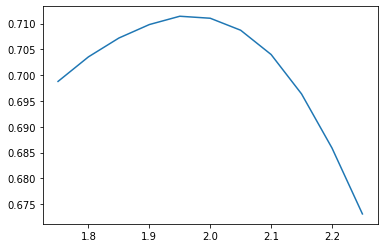

In [34]:
import matplotlib.pyplot as plt
plt.plot(thrshes, f1_lst)  

In [39]:
def find_best(dists, idx, thrshes = np.linspace(1.75,2.25,num=11)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    return f1_best, thrsh_best, preds_best

In [40]:
f1_best, thrsh_best, preds_best = find_best(dists, idx, thrshes)

100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


In [41]:
f1_best, thrsh_best

(0.7114063157597864, 1.95)